In [15]:
import shapely
import shapely.plotting
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from scipy.interpolate import griddata

MACHINE_EPSILON = 1e-10

In [16]:
class Material:
    def __init__(self, sigma_t, sigma_s, volumetric_source, name=None, color=None):
        self.sigma_t = sigma_t
        self.sigma_s = sigma_s
        self.volumetric_source = volumetric_source
        self.name = name
        self.color = color

class CellData:
    def __init__(self, cell: shapely.geometry.Polygon, material: Material):
        self.cell = cell
        self.material = material
        self.area = cell.area

        self.prior_flux = 0.0
        self.flux = 0.0
    
    def add_flux(self, flux):
        self.flux += flux / self.area
        
    def source(self):
        return self.material.volumetric_source + self.prior_flux * self.material.sigma_s
    
    def reset_flux_return_diff(self):
        difference = self.flux - self.prior_flux
        self.prior_flux = self.flux
        self.flux = 0.0
        return difference

def generate_ray(
    offset_from_center, line_angle, x_min, x_max, y_min, y_max
):
    """Generates a ray an angle `line_angle` that is offset by `offset_from_center` from the center of the problem domain
    in the direction perpendicular to the line angle.
    The ray is bounded by the problem domain.
    Theta is in radians and counterclockwise from the x-axis.
    """
    sin_theta = np.sin(line_angle)
    cos_theta = np.cos(line_angle)
    tan_theta = sin_theta / cos_theta

    x_center = (x_min + x_max) / 2
    y_center = (y_min + y_max) / 2

    # technically not the offset but just a point on the ray we are generating
    x_offset = x_center + offset_from_center * sin_theta
    y_offset = y_center - offset_from_center * cos_theta

    # point intercept form, slope is tan(theta)
    y_of_x = lambda x: tan_theta * (x - x_offset) + y_offset
    x_of_y = lambda y: (y - y_offset) / tan_theta + x_offset

    # edge case where ray intersects corners of the problem domain
    if (
        np.abs(x_max - x_min) == np.abs(y_max - y_min)
        and np.abs(line_angle) == np.pi / 4
        and offset_from_center == 0
    ):
        if line_angle > 0:
            return shapely.geometry.LineString([(x_min, y_min), (x_max, y_max)])
        else:
            return shapely.geometry.LineString([(x_min, y_max), (x_max, y_min)])

    # Calculate the intersection points with the problem domain boundaries
    points = []
    y_of_x_min = y_of_x(x_min)
    if y_min <= y_of_x_min <= y_max:
        points.append((x_min, y_of_x_min))

    y_of_x_max = y_of_x(x_max)
    if y_min <= y_of_x_max <= y_max:
        points.append((x_max, y_of_x_max))

    x_of_y_min = x_of_y(y_min)
    if x_min <= x_of_y_min <= x_max:
        points.append((x_of_y_min, y_min))

    x_of_y_max = x_of_y(y_max)
    if x_min <= x_of_y_max <= x_max:
        points.append((x_of_y_max, y_max))

    if len(points) == 0:
        return None

    assert (
        len(points) == 2
    ), f"Ray does not intersect the problem domain twice. It does {len(points)} times. Points: {points}"

    # Create a line string representing the ray
    ray = shapely.geometry.LineString(points)

    return ray


In [17]:
def normalize_angle(angle):
    """Normalize angle to range [-π, π]"""
    if angle == np.pi:
        return np.pi
    return (angle + np.pi) % (2 * np.pi) - np.pi


def get_ray_direction(line_angle):
    """Returns 1 if the ray is traveling from left to right
    and -1 if the ray is traveling from right to left.

    Line angle is in radians
    """
    # Normalize angle to range [-π, π]
    normalized_angle = normalize_angle(line_angle)
    pi_over_2 = np.pi / 2
    if -pi_over_2 < normalized_angle < pi_over_2:
        return 1
    else:
        return -1


def get_first_point(ray, line_angle):
    direction = get_ray_direction(line_angle)

    cord_a, cord_b = ray.coords
    cord_a_x = cord_a[0]
    cord_b_x = cord_b[0]
    if direction == 1:
        return cord_a if cord_a_x < cord_b_x else cord_b
    else:
        return cord_a if cord_a_x > cord_b_x else cord_b


def sort_intersecting_cells(ray, angle, cells):
    # Get ray starting point (first coordinate)
    ray_start = get_first_point(ray, angle)

    # Calculate distance from ray start to each cell's intersection point
    cell_distances = []
    for cell in cells:
        intersection = cell.intersection(ray)
        # If the intersection is a point, use that point
        # If it's a line segment, use its midpoint
        if intersection.geom_type == "Point":
            distance_point = intersection
        else:
            distance_point = intersection.centroid

        distance = shapely.distance(shapely.geometry.Point(ray_start), distance_point)
        cell_distances.append((cell, distance))

    # Sort cells by distance from ray start
    cell_distances.sort(key=lambda x: x[1])
    sorted_cells = [cell for cell, _ in cell_distances]
    return sorted_cells


def get_intersecting_cells(ray, angle, tree: shapely.STRtree):

    cell_idxs = tree.query(ray, predicate="intersects")

    cells = [tree.geometries.take(i) for i in cell_idxs]
    cells = [cell for cell in cells if cell.intersection(ray).length > 0]

    sorted_cells = sort_intersecting_cells(ray, angle, cells)

    return sorted_cells

In [18]:
class ProductQuadrature:
    def __init__(self, num_azimuthal, num_polar):
        """Azimuthal is planar, over [0, 2pi] space, polar is vertical, over [-pi/2, pi/2] space."""
        self.num_azimuthal = num_azimuthal
        self.num_polar = num_polar

        self.polar_mus, self.polar_weights = np.polynomial.legendre.leggauss(
            num_polar
        )
        self.polar_weights = self.polar_weights / 2

        azimuthal_angle_delta = 2 * np.pi / num_azimuthal
        self.azimuthal_angles = (
            np.arange(0, 2 * np.pi, azimuthal_angle_delta) + azimuthal_angle_delta / 2
        )
        self.azimuthal_weights = np.ones(num_azimuthal) * 1 / num_azimuthal

    def azimuthal_angles_weights(self):
        return zip(self.azimuthal_angles, self.azimuthal_weights)

    def polar_mus_weights(self):
        return zip(self.polar_mus, self.polar_weights)


class CartesianMOC:
    def __init__(
        self,
        cell_data_dict: dict[shapely.geometry.Polygon, CellData],
        quadrature: ProductQuadrature,
        bc_north = 0,
        bc_east = 0,
        bc_south = 0,
        bc_west = 0,
        ray_width=0.1,
        max_iterations=1000,
    ):
        self.cell_data_dict = cell_data_dict
        self.cell_data_list = list(cell_data_dict.values())
        self.quadrature = quadrature
        self.bc_north = bc_north
        self.bc_east = bc_east
        self.bc_south = bc_south
        self.bc_west = bc_west
        self.ray_width = ray_width
        self.max_iterations = max_iterations

        cells = [cell_data.cell for cell_data in self.cell_data_list]
        self.number_of_cells = len(cells)
        self.tree = shapely.STRtree(cells)

        domain = shapely.union_all(cells)
        self.x_min, self.y_min, self.x_max, self.y_max = domain.bounds
        self.max_ray_offset = (
            max(self.x_max - self.x_min, self.y_max - self.y_min) * 3 / 2
        )  # overestimate
        
        self.rays_dict = None

    def get_incident_scalar_flux(self, ray, angle):
        first_point = get_first_point(ray, angle)
        first_point_x = first_point[0]
        first_point_y = first_point[1]

        if first_point_x == self.x_min:
            return self.bc_west
        elif first_point_x == self.x_max:
            return self.bc_east
        elif first_point_y == self.y_min:
            return self.bc_south
        elif first_point_y == self.y_max:
            return self.bc_north
        else:
            raise
        
    def gen_rays(self):
        """
        azimuthal_angle : {
            offset : {
                ray : shapely.geometry.LineString,
                incident_scalar_flux : float,
                intersecting_cells : list[CellData],
                intersection_lengths : list[float],
            }
        }
        """
        self.rays_dict = {}
        for azimuthal_angle, azimuthal_weight in self.quadrature.azimuthal_angles_weights():
            angle_dict = {}
            
            for offset in np.arange(
                -self.max_ray_offset, self.max_ray_offset, self.ray_width
            ):
                ray = generate_ray(
                    offset,
                    azimuthal_angle,
                    self.x_min,
                    self.x_max,
                    self.y_min,
                    self.y_max,
                )
                # Need incident flux
                if ray is not None:
                    incident_flux = self.get_incident_scalar_flux(ray, azimuthal_angle)
                    intersecting_cells = get_intersecting_cells(ray, azimuthal_angle, self.tree)
                    intersecting_cell_datas = [self.cell_data_dict[cell] for cell in intersecting_cells]
                    intersection_lengths = [ray.intersection(cell).length for cell in intersecting_cells]
                    
                    offset_dict = {
                        "ray": ray,
                        "incident_scalar_flux": incident_flux,
                        "intersecting_cell_datas": intersecting_cell_datas,
                        "intersection_lengths": intersection_lengths,
                        "azimuthal_weight": azimuthal_weight,
                    }                     
                else :
                    offset_dict = None
                angle_dict[offset] = offset_dict
            self.rays_dict[azimuthal_angle] = angle_dict
            
        return self.rays_dict
                    

    def solve(self, tolerance=1e-6):

        [cell.reset_flux_return_diff() for cell in self.cell_data_list]
        
        if self.rays_dict == None:
            self.gen_rays()

        for iteration in range(self.max_iterations):
            # for azimuthal_angle, azimuthal_weight in self.quadrature.azimuthal_angles_weights():
            #     for offset in np.arange(
            #         -self.max_ray_offset, self.max_ray_offset, self.ray_width
            #     ):
            #         ray = generate_ray(
            #             offset,
            #             azimuthal_angle,
            #             self.x_min,
            #             self.x_max,
            #             self.y_min,
            #             self.y_max,
            #         )
            #         # Need incident flux
            #         if ray is not None:
            #             incident_flux = self.get_incident_scalar_flux(ray, azimuthal_angle)
            #             self.solve_ray(ray, incident_flux, azimuthal_angle, azimuthal_weight)
            for azimuthal_angle, angle_dict in self.rays_dict.items():
                for offset, offset_dict in angle_dict.items():
                    if offset_dict is not None:
                        self.solve_ray(**offset_dict)

            differences = [
                cell.reset_flux_return_diff() for cell in self.cell_data_list
            ]
            error = np.sqrt(sum([diff ** 2 for diff in differences])) / self.number_of_cells

            if np.isnan(error):
                raise
            print(f"Iter {iteration} error: {error:.6f}")
            if error < tolerance:
                print(f"Converged in {iteration} iterations with error {error:.6f}")
                break

    def solve_ray(self, ray : shapely.geometry.LineString, incident_scalar_flux, intersecting_cell_datas, intersection_lengths, azimuthal_weight):
        """Solves ray for all polar angles and adds the flux contribution to the cells based on the azimuthal weight."""
        for polar_mu, polar_weight in self.quadrature.polar_mus_weights():

            incident_angular_flux = incident_scalar_flux #  * polar_weight * azimuthal_weight

            for intersecting_cell_data, length in zip(intersecting_cell_datas, intersection_lengths):
                sigma_t = intersecting_cell_data.material.sigma_t
                mfp = sigma_t * length

                if mfp < MACHINE_EPSILON:
                    exiting_angular_flux = incident_angular_flux
                    average_angular_flux = incident_angular_flux
                else:
                    source = intersecting_cell_data.source()
                    source_over_sigma_t = source / sigma_t
                    tau = mfp / np.abs(polar_mu)
                    exp_term = np.exp(-tau)
                    exiting_angular_flux = incident_angular_flux * exp_term + source_over_sigma_t * (1 - exp_term)
                    average_angular_flux = source_over_sigma_t + (incident_angular_flux - exiting_angular_flux) / tau
                    assert np.isfinite(average_angular_flux) and average_angular_flux >= 0.0, f"Average flux is not finite: {average_angular_flux}"

                flux_contribution = average_angular_flux * polar_weight * azimuthal_weight * length * self.ray_width / 2
                intersecting_cell_data.add_flux(flux_contribution)

                incident_angular_flux = exiting_angular_flux

    def plot_scalar_flux(self):
        fig, ax = plt.subplots()
        values = [cell.prior_flux for cell in self.cell_data_list]
        patches = [mpatches.Polygon(cell.cell.exterior.coords, closed=True) for cell in self.cell_data_list]
        # Create the PatchCollection
        p = PatchCollection(
            patches, cmap="viridis", alpha=0.8, edgecolors="black", linewidths=1
        )
        p.set_array(np.array(values))
        ax.add_collection(p)
        cbar = plt.colorbar(p, ax=ax)
        ax.set_xlim(self.x_min, self.x_max)
        ax.set_ylim(self.y_min, self.y_max)
        ax.set_aspect("equal")


    def plot_scalar_flux_3D(self):
        """Creates a smooth 3D surface plot of the scalar flux."""
        fig = plt.figure(figsize=(12, 10))
        ax = fig.add_subplot(111, projection="3d")

        # Extract all cell centroids and flux values
        centroids = []
        flux_values = []
        for cell_data in self.cell_data_list:
            centroid = cell_data.cell.centroid
            centroids.append((centroid.x, centroid.y))
            flux_values.append(cell_data.prior_flux)

        # Create a regular grid over the domain
        x_grid = np.linspace(self.x_min, self.x_max, 100)
        y_grid = np.linspace(self.y_min, self.y_max, 100)
        X, Y = np.meshgrid(x_grid, y_grid)

        # Interpolate flux values onto the grid using scipy's griddata

        Z = griddata(centroids, flux_values, (X, Y), method="cubic", fill_value=0)

        # Create a smooth surface plot
        surf = ax.plot_surface(
            X, Y, Z, cmap="viridis", edgecolor=None, antialiased=True, alpha=0.8
        )

        # Add a wireframe to better visualize the 3D structure
        ax.plot_wireframe(X, Y, Z, color="black", alpha=0.1, linewidth=0.5)

        # Add the original cell polygons as points for reference
        centroid_xs = [c[0] for c in centroids]
        centroid_ys = [c[1] for c in centroids]
        ax.scatter(centroid_xs, centroid_ys, flux_values, color="red", s=10, alpha=0.5)

        # Set axis labels and limits
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Flux")
        ax.set_xlim(self.x_min, self.x_max)
        ax.set_ylim(self.y_min, self.y_max)
        ax.set_zlim(0, max(flux_values) * 1.1)

        # Add a colorbar
        cbar = fig.colorbar(surf, ax=ax, shrink=0.6, aspect=10)
        cbar.set_label("Scalar Flux")

        plt.title("Smooth 3D Scalar Flux Visualization")
        plt.tight_layout()

        return fig

In [19]:
materials = {
    "reflector": Material(2.0, 1.8, 0.0, "reflector", "blue"),
    "scatterer": Material(2.0, 1.99, 0.0, "scatterer", "red"),
    "absorber": Material(10.0, 2.0, 0.0, "absorber", "green"),
    "air": Material(0.1, 0.006, 0.0, "air", (0.9, 0.97, 1.0, 0.3)),
    "isotropic": Material(0.1, 0, 1, "isotropic", "purple"),
    "detector": Material(1.0, 0, 0, "detector", "yellow"),
    "vacuum": Material(0.0, 0.0, 0.0, "vacuum", "black"),
}

Iter 0 error: 0.005000
Iter 1 error: 0.002160
Iter 2 error: 0.000933
Iter 3 error: 0.000403
Iter 4 error: 0.000174
Iter 5 error: 0.000075
Iter 6 error: 0.000033
Iter 7 error: 0.000014
Iter 8 error: 0.000006
Iter 9 error: 0.000003
Iter 10 error: 0.000001
Iter 11 error: 0.000000
Converged in 11 iterations with error 0.000000


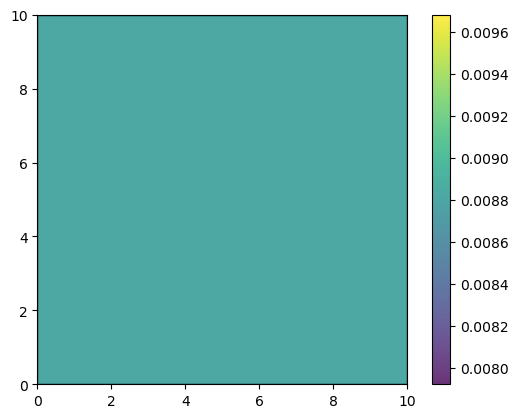

In [20]:
x_min = 0
x_max = 10
y_min = 0
y_max = 10

cell = shapely.geometry.box(x_min, y_min, x_max, y_max)
cell_data = CellData(cell, materials["reflector"])
cells = {cell: cell_data}

quadrature = ProductQuadrature(4, 2)
solver = CartesianMOC(cells, quadrature, bc_west=1)
solver.solve()
solver.plot_scalar_flux()


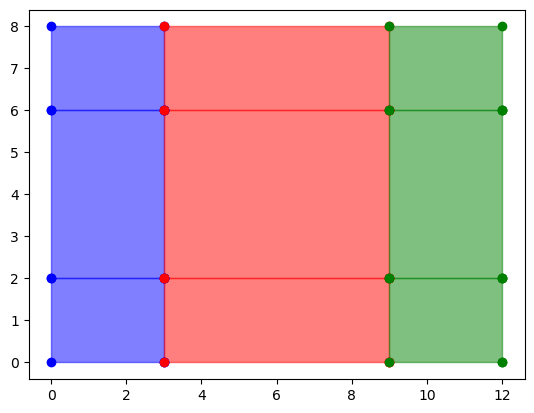

In [21]:
x_min = 0
x_max = 12
y_min = 0
y_max = 8

x_steps = [0, 3, 9, 12]
y_steps = [0, 2, 6, 8]

# create shapely boxes
cells = {}
for i in range(len(x_steps) - 1):
    if i == 0:
        material = materials["reflector"]
    elif i == 1:
        material = materials["scatterer"]
    elif i == 2:
        material = materials["absorber"]
    elif i == 3:
        material = materials["detector"]
    else:
        material = materials["air"]
    # material = materials["reflector"]
    for j in range(len(y_steps) - 1):
        cell = shapely.geometry.box(x_steps[i], y_steps[j], x_steps[i + 1], y_steps[j + 1])
        cells[cell] = CellData(cell, material)


fig, ax = plt.subplots()
for cell, cell_data in cells.items():
    # fig, ax = plt.subplots()
    # ax.set_xlim(x_min, x_max)
    # ax.set_ylim(y_min, y_max)
    shapely.plotting.plot_polygon(cell, color=cell_data.material.color, alpha=0.5, ax=ax)

Iter 0 error: 0.005950
Iter 1 error: 0.002440
Iter 2 error: 0.001012
Iter 3 error: 0.000423
Iter 4 error: 0.000179
Iter 5 error: 0.000076
Converged in 5 iterations with error 0.000076


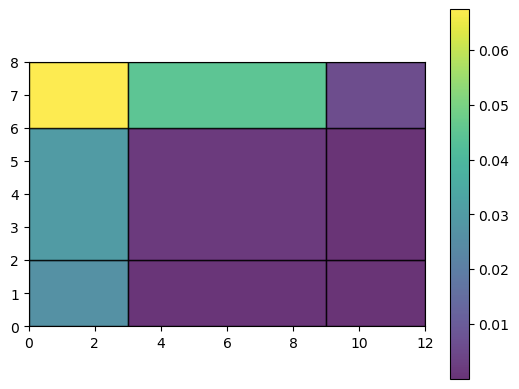

In [22]:
quadrature = ProductQuadrature(4, 2)
solver = CartesianMOC(cells, quadrature, bc_west=1, bc_north=1)
solver.solve(tolerance=1e-4)
solver.plot_scalar_flux()

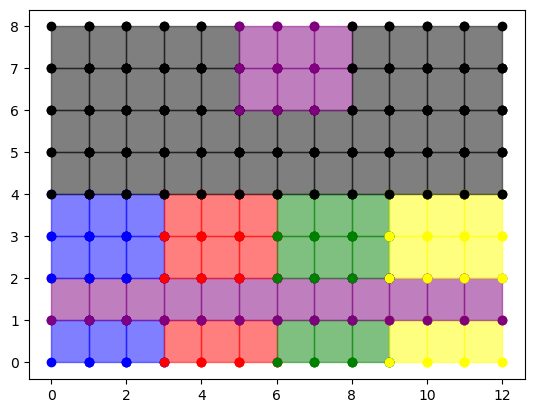

In [23]:
x_min = 0
x_max = 12
y_min = 0
y_max = 8

x_steps = np.arange(x_min, x_max + 1, 1)
y_steps = np.arange(y_min, y_max + 1, 1)

# create shapely boxes
cells = {}
for i in range(len(x_steps) - 1):

    # material = materials["air"]
    for j in range(len(y_steps) - 1):
        
        if 0 <= i < 3:
            material = materials["reflector"]
        elif 3 <= i < 6:
            material = materials["scatterer"]
        elif 6 <= i < 9:
            material = materials["absorber"]
        elif 9 <= i < 12:
            material = materials["detector"]
        
        if j >= 4:
            material = materials["vacuum"]
            
        if 6 <= j < 8 and 5 <= i < 8:
            material = materials["isotropic"]
            
        if j == 1:
            material = materials["isotropic"]
            
        cell = shapely.geometry.box(
            x_steps[i], y_steps[j], x_steps[i + 1], y_steps[j + 1]
        )
        cells[cell] = CellData(cell, material)


fig, ax = plt.subplots()
for cell, cell_data in cells.items():
    # fig, ax = plt.subplots()
    # ax.set_xlim(x_min, x_max)
    # ax.set_ylim(y_min, y_max)
    shapely.plotting.plot_polygon(
        cell, color=cell_data.material.color, alpha=0.5, ax=ax
    )


Iter 0 error: 0.046760
Iter 1 error: 0.001709
Iter 2 error: 0.000730
Iter 3 error: 0.000315
Iter 4 error: 0.000137
Iter 5 error: 0.000060
Converged in 5 iterations with error 0.000060


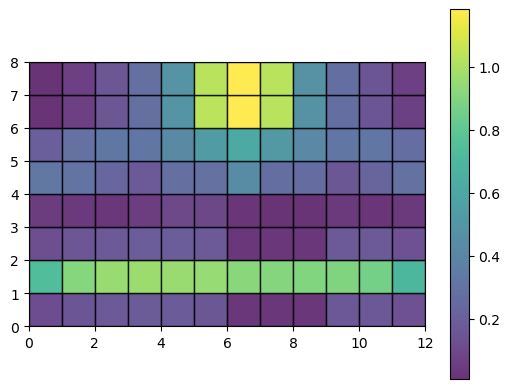

In [24]:

quadrature = ProductQuadrature(8, 4)
solver = CartesianMOC(cells, quadrature)#), bc_west=100)#, bc_north=50, bc_south=50)
solver.solve(tolerance=1e-4)
solver.plot_scalar_flux()

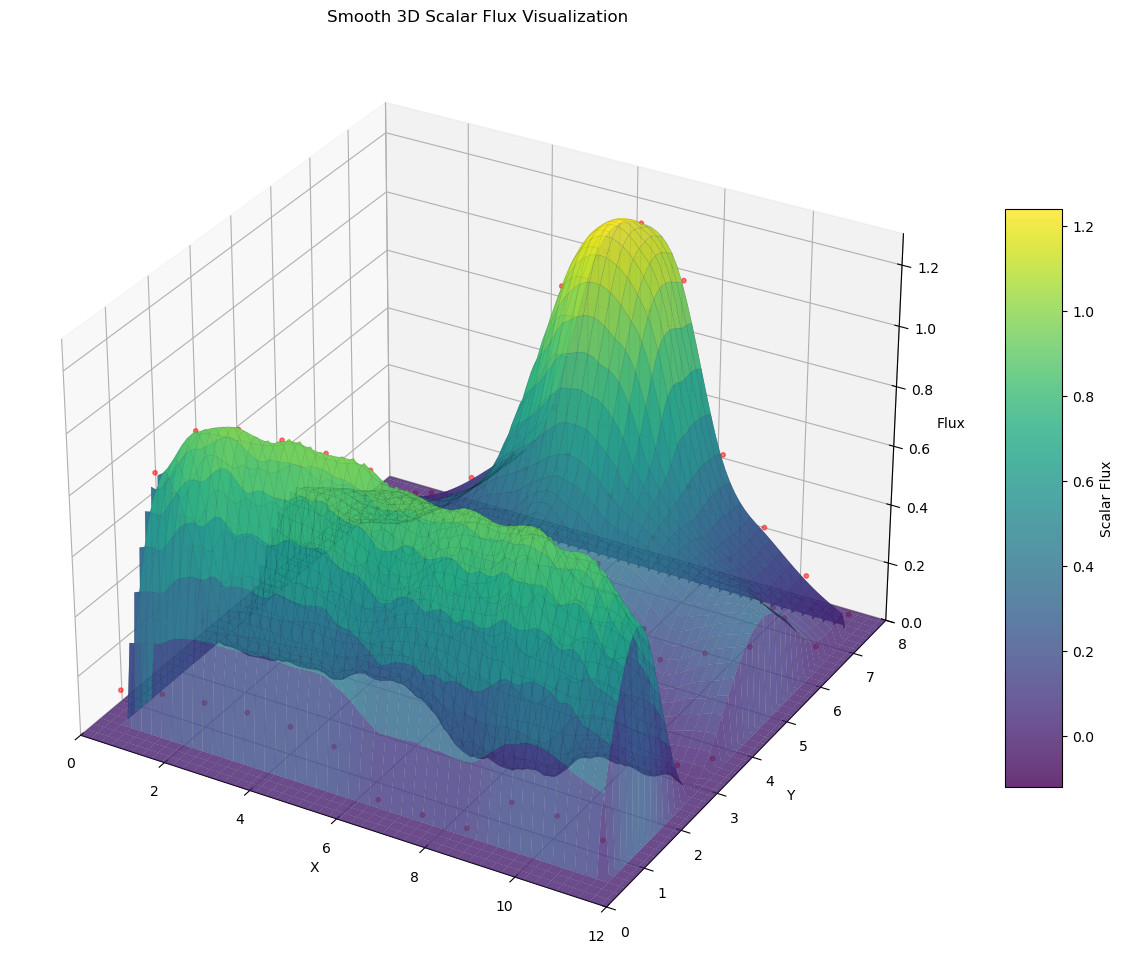

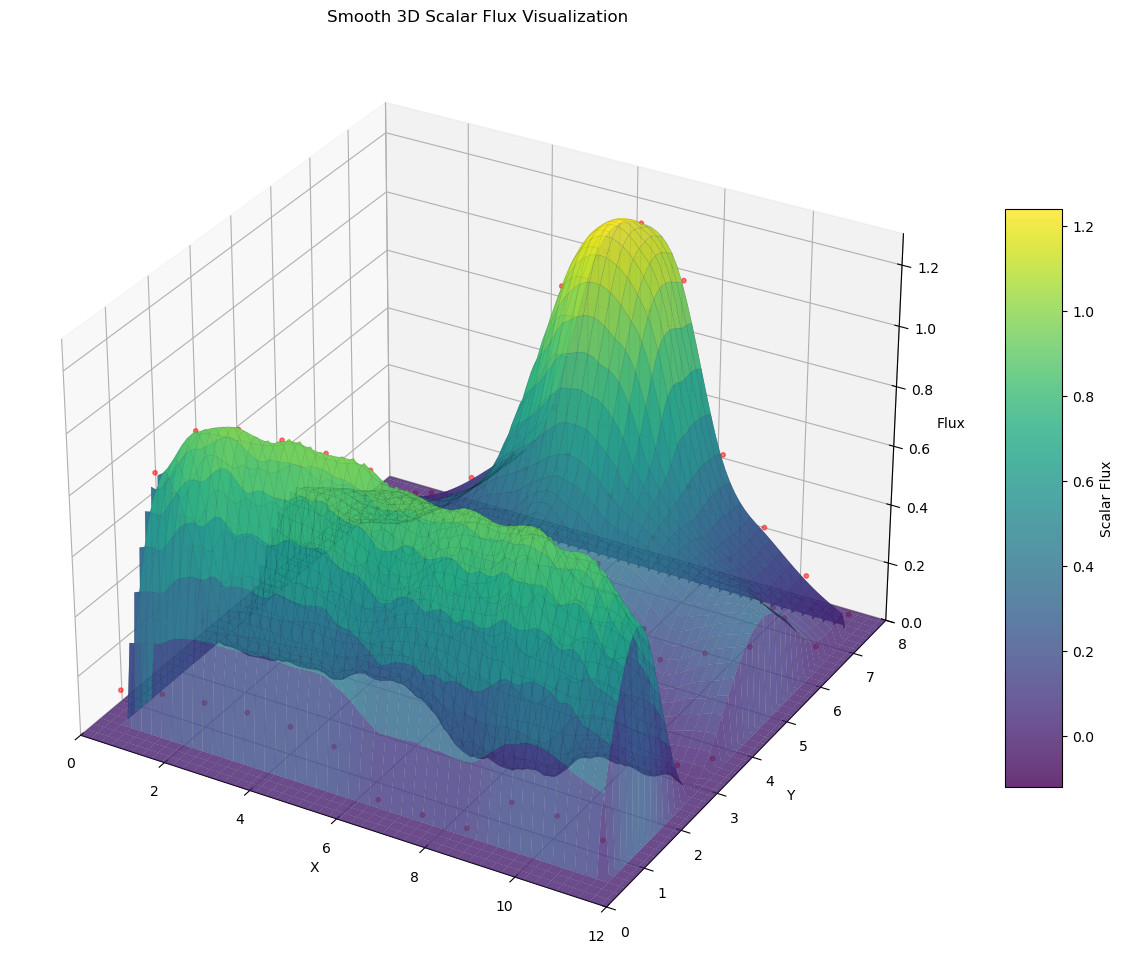

In [25]:
solver.plot_scalar_flux_3D()